## Imports

In [ ]:
!pip install numpy==1.25.2

In [ ]:
import os
import jax
import numpyro
import numpy as np
import pandas as pd
import glob

import matplotlib.pyplot as plt
import hssm
import arviz as az
import seaborn as sns

jax.config.update('jax_platform_name', 'cpu')
hssm.set_floatX("float32")
numpyro.set_host_device_count(14)

In [ ]:
df_raw = pd.read_stata('Data_Exp1234_clean.dta')

In [ ]:
df_raw

## Definitions

In [ ]:
def subsitute_values_sequential(data,varname,new_values):
  unique_values = sorted(data[varname].unique())
  substitutions = {val: new_val for val, new_val in zip(unique_values,new_values)}
  return  data[varname].replace(substitutions)

In [ ]:
def robust_z(x):
    x = np.asarray(x, float)
    med = np.median(x)
    mad = np.median(np.abs(x - med))
    return 0.6745 * (x - med) / (mad if mad>0 else np.finfo(float).eps)

### Data Cleanup

In [ ]:
columns_to_keep = [
    'id',              # Participant ID (for hierarchical fitting)
    'trial',           # Trial Number (for indexing/sequencing)
    'experiment',      # Filter column (must be 4)
    'rt',              # Response Time (The dependent variable distribution)
    'correct',         # Accuracy (The outcome predicted by DDM)
    'ab_nominal',      # Accuracy Bonus (Incentive condition)
    'stake_nominal',   # Loss Size (Incentive condition)
    'difficult',        # Task Difficulty (Signal quality condition)
    'endowment',      # Initial amount (Incentive con
]

In [ ]:
df_raw.columns

In [ ]:
df_raw.stake_nominal = df_raw.stake_nominal.fillna(0)

In [ ]:
df_raw

In [ ]:
data = df_raw.copy()
data = data[columns_to_keep]

data.rename(columns={
    'id':'participant'
}, inplace=True)

## Stim evidence: low vs high (0/1)
#data['endowment_2'] = subsitute_values_sequential(data,'stim_strength',[0.25,.5,0.75,1])

MIN_RT = 200 
MAX_RT = 35000 
MAD_THRESH_RT = 3

ACC_THRESH_LO = 0.525 
ACC_THRESH_HI = 0.975

MIN_TRIALS_PER_COND = 8
COND_VARS = ['endowment']

#count original number of trials before exclusion
n_trials_raw= len(data)

In [ ]:
df_raw

In [ ]:
data = data[(~data['correct'].isna()) & (~data['rt'].isna())
             & (data['rt']> MIN_RT) & (data['rt'] < MAX_RT) & (~data['correct'].isna())]

In [ ]:
data = data[data.groupby('participant')['rt'].transform(lambda x: abs(robust_z(x)))<MAD_THRESH_RT]

In [ ]:
print('N trials excluded = %i / %i'%(n_trials_raw - len(data),n_trials_raw))

print('Mean RT = %i ms, median RT = %i ms, max RT = %i ms' % (data['rt'].mean(),data['rt'].median(),data['rt'].max()))

## Participant Cleanup

In [ ]:
participant_accuracy = data.groupby('participant')['correct'].mean()
valid_participants = participant_accuracy[(participant_accuracy > ACC_THRESH_LO) & (participant_accuracy < ACC_THRESH_HI)].index

print('N participants kept (accuracy) = %i / %i'%(len(valid_participants),len(data['participant'].unique())))
data = data[data['participant'].isin(valid_participants)]

#remove participants with extreme median RTs compared to sample
participant_rt = data.groupby('participant')['rt'].median()
valid_participants_rt = participant_rt[np.abs(robust_z(participant_rt))<3].index
print('N participants kept (RT) = %i / %i'%(len(valid_participants_rt),len(data['participant'].unique())))
data = data[data['participant'].isin(valid_participants_rt)]

# remove participants, who, after exclsion, have too few trials for one or more conditions
groupby_vars = ['participant']
groupby_vars.extend(COND_VARS)
sub_trials_per_cond = data.groupby(groupby_vars).size().reset_index(name='n_trials')

#get list of participants that have at least min_trials_per_cond trials per condition (combination of incentive and desirability values)
df_participants_with_min_trials = sub_trials_per_cond.groupby('participant').filter(lambda x: (x['n_trials'] >= MIN_TRIALS_PER_COND).all())
valid_participants = df_participants_with_min_trials['participant'].unique().tolist()
print('N participants kept after excluding participants with too few trials = %i / %i'%(len(valid_participants),len(data['participant'].unique())))
data = data[data['participant'].isin(valid_participants)]

## HSSM DataFrame

In [ ]:
data

In [ ]:
df_hssm = pd.DataFrame({
    'response': data['correct'].astype('int32'),
    'rt': (data['rt'] / 1000).astype('float32'),
    'participant_id': data['participant'].astype('int32')
})

df_hssm = df_hssm.astype({col: 'float32' for col in df_hssm.select_dtypes(include='float64').columns})

In [ ]:
df_hssm

In [98]:
random_ids = np.random.choice(
    df_hssm.participant_id.unique(),
    size=round(len(df_hssm.participant_id.unique())/20),
    replace = False
)

In [99]:
df_test = df_hssm[df_hssm['participant_id'].isin(random_ids)]

In [100]:
df_test

,response,rt,participant_id
22142,1,1.3960,187
22143,0,1.2930,187
22144,1,1.8890,187
22145,1,2.3750,187
22146,1,1.5910,187
...,...,...,...
76890,1,5.0769,867
76891,0,3.6807,867
76892,1,3.7069,867
76893,1,1.7773,867


In [101]:
len(df_raw.id.unique())

1114

In [102]:
len(df_test.participant_id.unique())

5

## Fit model

In [ ]:
results = []

In [ ]:
df_sub = df_test

In [ ]:
#for nsub, isub in enumerate(df_hssm['participant_id'].unique()):
for nsub, isub in enumerate(df_test['participant_id'].unique()):
    print(f"___Participant {isub}, {nsub+1}/{len(df_hssm['participant_id'].unique())}___")

    participant_folder = f"plots/Exp4/S{int(isub):04d}"   
    os.makedirs(participant_folder, exist_ok=True)

    df_hssm = df_test

    df_sub = df_hssm[df_hssm['participant_id'] == isub]
    df_sub.drop('participant_id', axis = 1, inplace=True)

    print("Median RT =", np.median(df_sub['rt']))
    print("N trials =", len(df_sub))

    model = hssm.HSSM(
        model="ddm",
        data=df_sub,

    )

    infer_data_sub = model.sample(
        cores=3,
        chains=3,
        draws=300,
        tune=1000,
        idata_kwargs=dict(log_likelihood=True),
        progressbar=True,
        target_accept=0.99,
    )

    fit_dict = infer_data_sub.to_dict()

    summary_table = az.summary(infer_data_sub)
    print(summary_table.to_string())
    with open(os.path.join(participant_folder, "summary_table.txt"), "w") as file:
        file.write(summary_table.to_string())

        # Save plots
    az.plot_posterior(infer_data_sub)
    plt.savefig(os.path.join(participant_folder, "posterior_plot.png"))
    plt.close()

In [ ]:
summary_table

In [ ]:
fit_dict

In [ ]:
# Base folder containing participant subfolders
base_folder = "plots/Exp4"

all_summaries = []

# Find all summary_table.txt files recursively
txt_files = glob.glob(os.path.join(base_folder, "S*", "summary_table.txt"))

for txt_file in txt_files:
    # Extract participant id from folder name
    participant_id = int(os.path.basename(os.path.dirname(txt_file))[1:])  # 'S0001' -> 1
    
    # Read the txt table
    try:
        df = pd.read_csv(txt_file, delim_whitespace=True, index_col=0)
    except pd.errors.ParserError:
        # fallback if the txt is formatted as a print(table)
        df = pd.read_fwf(txt_file, index_col=0)
    
    df['participant_id'] = participant_id
    all_summaries.append(df.reset_index().rename(columns={'index':'param'}))

# Concatenate all participants into a single DataFrame
df_all = pd.concat(all_summaries, ignore_index=True)

print(df_all.head())

In [ ]:
df_all

In [ ]:
df_v = df_all[df_all['param']=='v']

In [ ]:
sns.kdeplot(df_v['mean'])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for drift rate (v_Intercept)
df_v = df_all[df_all['param'] == 'v']

plt.figure(figsize=(8, 5))
sns.kdeplot(df_v['mean'], fill=True, bw_adjust=0.5)
sns.rugplot(df_v['mean'], color='k')
plt.xlabel("Drift rate (v_Intercept)")
plt.ylabel("Density")
plt.title("Distribution of fitted drift rates across participants")
plt.tight_layout()
plt.show()


In [ ]:
all_summary = []


# Model 2 test

In [ ]:
import datetime
today_date = datetime.date.today().strftime("%Y%m%d")

In [ ]:
today_date

In [ ]:
model_pureddm = hssm.HSSM(
    model="ddm",
    data=df_sub,

)

In [ ]:
model_v_intercept = hssm.HSSM(
    model="ddm",
    data=df_sub,
    include=[
        {
            "name":"v",
            "formula":"v ~ 1",
            "prior":{"Intercept":{"name":"Normal","mu":0,"sigma":1}}
        },
    ]
)

In [ ]:
def fit_hssm_participant(df, participant_column, model):
    results = []
    for nsub, isub in enumerate(df[participant_column].unique()):
        print(f"___Participant {isub}, {nsub+1}/{len(df[participant_column].unique())}___")

        participant_folder = f"plots/Exp4_{today_date}/S{int(isub):04d}"   
        os.makedirs(participant_folder, exist_ok=True)

        df_sub = df[df[participant_column] == isub]
        df_sub = df_sub.drop(participant_column, axis = 1)

        print("Median RT =", np.median(df_sub['rt']))
        print("N trials =", len(df_sub))

        model = hssm.HSSM(
        model="ddm",
        data=df_sub,
        )

        infer_data_sub = model.sample(
                cores=3,
                chains=3,
                draws=300,
                tune=1000,
                idata_kwargs=dict(log_likelihood=True),
                progressbar=True,
                target_accept=0.99,
            )

        fit_dict = infer_data_sub.to_dict()

        summary_table = az.summary(infer_data_sub)
        print(summary_table.to_string())
        with open(os.path.join(participant_folder, "summary_table.txt"), "w") as file:
            file.write(summary_table.to_string())

            # Save plots
        az.plot_posterior(infer_data_sub)
        plt.savefig(os.path.join(participant_folder, "posterior_plot.png"))
        plt.close()

In [116]:
include_1 = [
            {
                "name":"v",
                "formula":"v ~ 1",
                "prior":{"Intercept":{"name":"Normal","mu":0,"sigma":1}}
            },
        ]

In [118]:
def fit_hssm_participant(df, participant_column):
    all_summaries = []
    all_inferences = {}   # <- store InferData here

    for nsub, isub in enumerate(df[participant_column].unique()):
        print(f"___Participant {isub}, {nsub+1}/{df[participant_column].nunique()}___")

        df_sub = df[df[participant_column] == isub].drop(columns=[participant_column])

        print("Median RT =", np.median(df_sub['rt']))
        print("N trials =", len(df_sub))

        model = hssm.HSSM(
            model="ddm",
            data=df_sub,
        )

        infer_data_sub = model.sample(
            cores=3,
            chains=3,
            draws=300,
            tune=1000,
            idata_kwargs=dict(log_likelihood=True),
            progressbar=True,
            target_accept=0.99,
        )

        all_inferences[isub] = infer_data_sub

        summary_df = (
            az.summary(infer_data_sub)
              .reset_index()
              .rename(columns={'index': 'param'})
        )
        summary_df['participant_id'] = isub
        all_summaries.append(summary_df)

    all_summaries_df = pd.concat(all_summaries, ignore_index=True)
    return all_summaries_df, all_inferences

In [119]:
a,b = fit_hssm_participant(df_test, 'participant_id')

___Participant 187, 1/5___
Median RT = 1.4865
N trials = 82


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [a, z, t, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 415, 2/5___
Median RT = 0.884
N trials = 84


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [a, z, t, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 24 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Only 300 samples in chain.


___Participant 725, 3/5___
Median RT = 1.2222
N trials = 73


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [a, z, t, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 75 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 849, 4/5___
Median RT = 1.114
N trials = 81


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [a, z, t, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 68 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 867, 5/5___
Median RT = 3.2678
N trials = 77


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [a, z, t, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [120]:
a

,param,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,participant_id
0,v,0.605,0.157,0.304,0.899,0.007,0.005,475.0,513.0,1.00,187
1,a,1.001,0.065,0.888,1.128,0.003,0.002,476.0,540.0,1.00,187
2,z,0.574,0.046,0.483,0.655,0.002,0.002,439.0,411.0,1.00,187
3,t,0.847,0.035,0.775,0.918,0.002,0.001,406.0,307.0,1.00,187
4,v,1.928,0.297,1.445,2.510,0.015,0.011,394.0,558.0,1.01,415
5,a,0.809,0.065,0.674,0.919,0.003,0.002,379.0,363.0,1.01,415
6,z,0.408,0.053,0.303,0.502,0.003,0.002,422.0,504.0,1.00,415
7,t,0.487,0.021,0.444,0.522,0.001,0.001,373.0,467.0,1.01,415
8,v,0.797,0.219,0.424,1.250,0.016,0.012,189.0,250.0,1.02,725
9,a,0.868,0.061,0.760,0.975,0.004,0.003,202.0,489.0,1.00,725


array([<Axes: title={'center': 'v'}>, <Axes: title={'center': 'a'}>,
       <Axes: title={'center': 'z'}>, <Axes: title={'center': 't'}>],
      dtype=object)

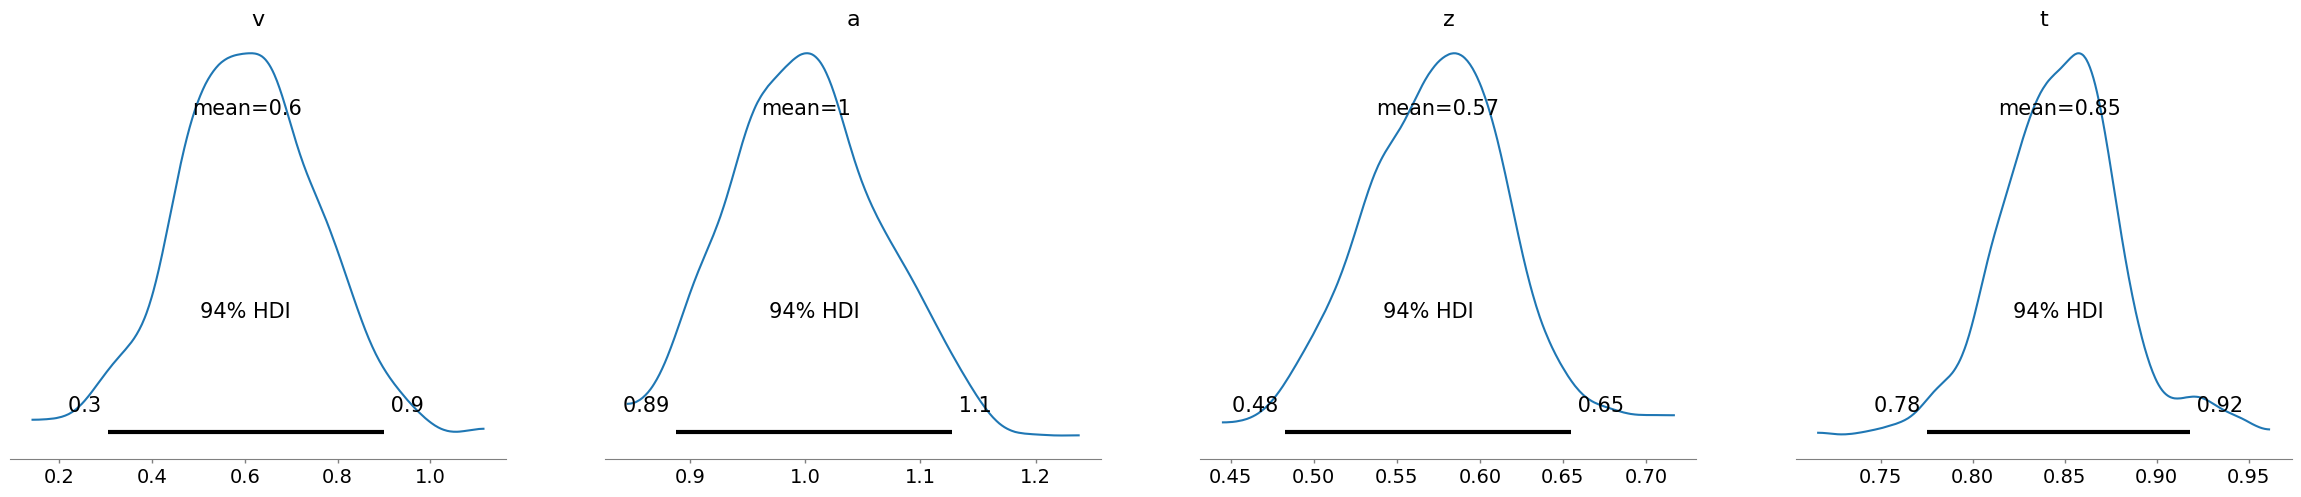

In [121]:
az.plot_posterior(b[187])

In [103]:
df_test

,response,rt,participant_id
22142,1,1.3960,187
22143,0,1.2930,187
22144,1,1.8890,187
22145,1,2.3750,187
22146,1,1.5910,187
...,...,...,...
76890,1,5.0769,867
76891,0,3.6807,867
76892,1,3.7069,867
76893,1,1.7773,867


In [ ]:
for nsub, isub in enumerate(df_test['participant_id'].unique()):
    print(f"___Participant {isub}, {nsub+1}/{len(df_test['participant_id'].unique())}___")

    participant_folder = f"plots/Exp4/S{int(isub):04d}"   
    os.makedirs(participant_folder, exist_ok=True)

    df_hssm = df_test

    df_sub = df_hssm[df_hssm['participant_id'] == isub]
    df_sub.drop('participant_id', axis = 1, inplace=True)

    print("Median RT =", np.median(df_sub['rt']))
    print("N trials =", len(df_sub))

    model = hssm.HSSM(
        model="ddm",
        data=df_sub,
        include=[
            {
                "name":"v",
                "formula":"v ~ 1",
                "prior":{"Intercept":{"name":"Normal","mu":0,"sigma"1}}
            },
        ]
    )

    infer_data_sub = model.sample(
        cores=3,
        chains=3,
        draws=300,
        tune=1000,
        idata_kwargs=dict(log_likelihood=True),
        progressbar=True,
        target_accept=0.99,
    )

    fit_dict = infer_data_sub.to_dict()

    summary_table = az.summary(infer_data_sub).reset_index().rename(columns={'index':'param'})
    summary_table['participant_id'] = isub
    all_summary.append(summary_table)

    # Save posterior plot (optional)
    az.plot_posterior(infer_data_sub)
    plt.savefig(os.path.join(participant_folder, "posterior_plot.png"))
    plt.close()

In [ ]:
df_all = pd.concat(all_summary, ignore_index=True)